In [70]:
import geopandas
from libpysal import examples
import matplotlib
import mip
import numpy
import os
import spaghetti
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline

In [71]:
supply_cafes = [1, 6, 4, 5]
demand_cafes = [2, 3, 7, 8]

In [72]:
amount_supply = [40, 60, 30, 70]
amount_demand = [10, 90, 20, 80]

In [73]:
class TransportationProblem:
    def __init__(
        self,
        supply_nodes,
        demand_nodes,
        cij,
        si,
        dj,
        xij_tag="x_%s,%s",
        supply_constr_tag="supply(%s)",
        demand_constr_tag="demand(%s)",
        solver="cbc",
        display=True,
    ):
        """Instantiate and solve the Primal Transportation Problem
        based the formulation from Daskin (2013, Ch. 2).

        Parameters
        ----------
        supply_nodes : geopandas.GeoSeries
            Supply node decision variables.
        demand_nodes : geopandas.GeoSeries
            Demand node decision variables.
        cij : numpy.array
            Supply-to-demand distance matrix for nodes.
        si : geopandas.GeoSeries
            Amount that can be supplied by each supply node.
        dj : geopandas.GeoSeries
            Amount that can be received by each demand node.
        xij_tag : str
            Shipping decision variable names within the model. Default is
            'x_%s,%s' where %s indicates string formatting.
        supply_constr_tag : str
            Supply constraint labels. Default is 'supply(%s)'.
        demand_constr_tag : str
            Demand constraint labels. Default is 'demand(%s)'.
        solver : str
            Default is 'cbc' (coin-branch-cut). Can be set
            to 'gurobi' (if Gurobi is installed).
        display : bool
            Print out solution results.

        Attributes
        ----------
        supply_nodes : See description in above.
        demand_nodes : See description in above.
        cij : See description in above.
        si : See description in above.
        dj : See description in above.
        xij_tag : See description in above.
        supply_constr_tag : See description in above.
        demand_constr_tag : See description in above.
        rows : int
            The number of supply nodes.
        rrows : range
            The index of supply nodes.
        cols : int
            The number of demand nodes.
        rcols : range
            The index of demand nodes.
        model : mip.model.Model
            Integer Linear Programming problem instance.
        xij : numpy.array
            Shipping decision variables (``mip.entities.Var``).
        """

        # all nodes to be visited
        self.supply_nodes, self.demand_nodes = supply_nodes, demand_nodes
        # shipping costs (distance matrix) and amounts
        self.cij, self.si, self.dj = cij, si.values, dj.values
        self.ensure_float()
        # alpha tag for decision variables
        self.xij_tag = xij_tag
        # alpha tag for supply and demand constraints
        self.supply_constr_tag = supply_constr_tag
        self.demand_constr_tag = demand_constr_tag

        # instantiate a model
        self.model = mip.Model(" TransportationProblem", solver_name=solver)
        # define row and column indices
        self.rows, self.cols = self.si.shape[0], self.dj.shape[0]
        self.rrows, self.rcols = range(self.rows), range(self.cols)
        # create and set the decision variables
        self.shipping_dvs()
        # set the objective function
        self.objective_func()
        # add supply constraints
        self.add_supply_constrs()
        # add demand constraints
        self.add_demand_constrs()
        # solve
        self.solve(display=display)
        # shipping decisions lookup
        self.get_decisions(display=display)

    def ensure_float(self):
        """Convert integers to floats (rough edge in mip.LinExpr)"""
        self.cij = self.cij.astype(float)
        self.si = self.si.astype(float)
        self.dj = self.dj.astype(float)

    def shipping_dvs(self):
        """Create the shipping decision variables - eq (4)."""

        def _s(_x):
            """Helper for naming variables"""
            return self.supply_nodes[_x].split("_")[-1]

        def _d(_x):
            """Helper for naming variables"""
            return self.demand_nodes[_x].split("_")[-1]

        xij = numpy.array(
            [
                [self.model.add_var(self.xij_tag % (_s(i), _d(j))) for j in self.rcols]
                for i in self.rrows
            ]
        )
        self.xij = xij

    def objective_func(self):
        """Add the objective function - eq (1)."""
        self.model.objective = mip.minimize(
            mip.xsum(
                self.cij[i, j] * self.xij[i, j] for i in self.rrows for j in self.rcols
            )
        )

    def add_supply_constrs(self):
        """Add supply contraints to the model - eq (2)."""
        for i in self.rrows:
            rhs, label = self.si[i], self.supply_constr_tag % i
            self.model += mip.xsum(self.xij[i, j] for j in self.rcols) <= rhs, label

    def add_demand_constrs(self):
        """Add demand contraints to the model - eq (3)."""
        for j in self.rcols:
            rhs, label = self.dj[j], self.demand_constr_tag % j
            self.model += mip.xsum(self.xij[i, j] for i in self.rrows) >= rhs, label

    def solve(self, display=True):
        """Solve the model"""
        self.model.optimize()
        if display:
######################################################################
            obj = round(self.model.objective_value, 5)
            print("Minimized shipping costs: %s" % obj)

    def get_decisions(self, display=True):
        """Fetch the selected decision variables."""
        shipping_decisions = {}
        if display:
            print("\nShipping decisions:")
        for i in self.rrows:
            for j in self.rcols:
                v, vx = self.xij[i, j], self.xij[i, j].x
                if vx > 0:
                    if display:
                        print("\t", v, vx)
                    shipping_decisions[v.name] = vx
        self.shipping_decisions = shipping_decisions

    def print_lp(self, name=None):
        """Save LP file in order to read in and print."""
        if not name:
            name = self.model.name
        lp_file_name = "%s.lp" % name
        self.model.write(lp_file_name)
        lp_file = open(lp_file_name, "r")
        lp = lp_file.read()
        print("\n", lp)
        lp_file.close()
        os.remove(lp_file_name)

    def extract_shipments(self, paths, id_col, ship="ship"):
        """Extract the supply to demand shipments as a
        ``geopandas.GeoDataFrame`` of ``shapely.geometry.LineString`` objects.

        Parameters
        ----------
        paths : geopandas.GeoDataFrame
            Shortest-path routes between all ``self.supply_nodes``
            and ``self.demand_nodes``.
        id_col : str
            ID column name.
        ship : str
            Column name for the amount of good shipped.
            Default is 'ship'.

        Returns
        -------
        shipments : geopandas.GeoDataFrame
            Optimal shipments from ``self.supply_nodes`` to
            ``self.demand_nodes``.
        """

        def _id(sp):
            """ID label helper"""
            return tuple([int(i) for i in sp.split("_")[-1].split(",")])

        paths[ship] = int
        # set label of the shipping path for each OD pair.
        for ship_path, shipment in self.shipping_decisions.items():
            paths.loc[(paths[id_col] == _id(ship_path)), ship] = shipment
        # extract only shiiping paths
        shipments = paths[paths[ship] != int].copy()
        shipments[ship] = shipments[ship].astype(int)

        return shipments

In [74]:
shipping_colors = ["maroon", "cyan", "magenta", "orange", "green"]

In [75]:
def obs_labels(o, b, s, col="id", **kwargs):
    """Label each point pattern observation."""

    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]

    if o.index.name != "cafes":
        X = o.index.name[0]
    else:
        X = ""
    kws = {"size": s, "ha": "left", "va": "bottom", "style": "oblique"}
    kws.update(kwargs)
    o.apply(lambda x: b.annotate(text=X+str(x[col]), xy=_lab_loc(x), **kws), axis=1)

In [76]:
def make_patches(objects):
    """Create patches for legend"""
    patches = []
    for _object in objects:
        try:
            oname = _object.index.name
        except AttributeError:
            oname = "shipping"
        if oname.split(" ")[0] in ["cafes", "supply", "demand"]:
            ovalue = _object.shape[0]
            if oname == "cafes":
                ms, m, c, a = 3, "o", "k", 1
            elif oname.startswith("supply"):
                ms, m, c, a = 10, "o", "b", 0.25
            elif oname.startswith("demand"):
                ms, m, c, a = 10, "o", "g", 0.25
            if oname.endswith("snapped"):
                ms, m, a = float(ms) / 2.0, "x", 1
            _kws = {"lw": 0, "c": c, "marker": m, "ms": ms, "alpha": a}
            label = "%s — %s" % (oname.capitalize(), int(ovalue))
            p = matplotlib.lines.Line2D([], [], label=label, **_kws)
            patches.append(p)
        else:
            patch_info = plot_shipments(_object, "", for_legend=True)
            for c, lw, lwsc, (i, j) in patch_info:
                label = "s%s$\\rightarrow$d%s — %s straws" % (i, j, lw)
                _kws = {"alpha": 0.75, "c": c, "lw": lwsc, "label": label}
                p = matplotlib.lines.Line2D([], [], solid_capstyle="round", **_kws)
                patches.append(p)
    return patches

In [77]:
def legend(objects, anchor=(1.005, 1.016)):
    """Add a legend to a plot"""
    patches = make_patches(objects)
    kws = {"fancybox": True, "framealpha": 0.85, "fontsize": "x-large"}
    kws.update({"bbox_to_anchor":anchor, "labelspacing":2., "borderpad":2.})
    legend = matplotlib.pyplot.legend(handles=patches, **kws)
    legend.get_frame().set_facecolor("white")

In [78]:
def plot_shipments(sd, b, scaled=0.75, for_legend=False):
    """Helper for plotting shipments based on OD and magnitude"""
    _patches = []
    _plot_kws = {"alpha":0.75, "zorder":0, "capstyle":"round"}
    for c, (g, gdf) in zip(shipping_colors, sd):
        lw, lw_scaled, ids = gdf["ship"], gdf["ship"] * scaled, gdf["id"]
        if for_legend:
            for _lw, _lwsc, _id in zip(lw, lw_scaled, ids):
                _patches.append([c, _lw, _lwsc, _id])
        else:
            gdf.plot(ax=b, color=c, lw=lw_scaled, **_plot_kws)
    if for_legend:
        return _patches

In [79]:
streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "esri:102649"
streets = streets.to_crs("epsg:2762")

In [80]:
cafes = geopandas.read_file(examples.get_path("schools.shp"))
cafes.index.name = "cafes"
cafes.crs = "esri:102649"
cafes = cafes.to_crs("epsg:2762")

In [81]:
cafes_supply = cafes[cafes["POLYID"].isin(supply_cafes)]
cafes_supply.index.name = "supply"
cafes_supply

,POLYID,geometry
supply,,
0,1,POINT (221615.157 268183.063)
3,4,POINT (220453.142 268087.516)
4,5,POINT (221235.835 267685.028)
5,6,POINT (221542.706 268185.028)


In [82]:
cafes_demand = cafes[cafes["POLYID"].isin(demand_cafes)]
cafes_demand.index.name = "demand"
cafes_demand

,POLYID,geometry
demand,,
1,2,POINT (221122.271 268131.466)
2,3,POINT (221474.669 267188.462)
6,7,POINT (221847.882 267983.231)
7,8,POINT (221406.839 267990.801)


In [83]:
ntw = spaghetti.Network(in_data=streets)
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)


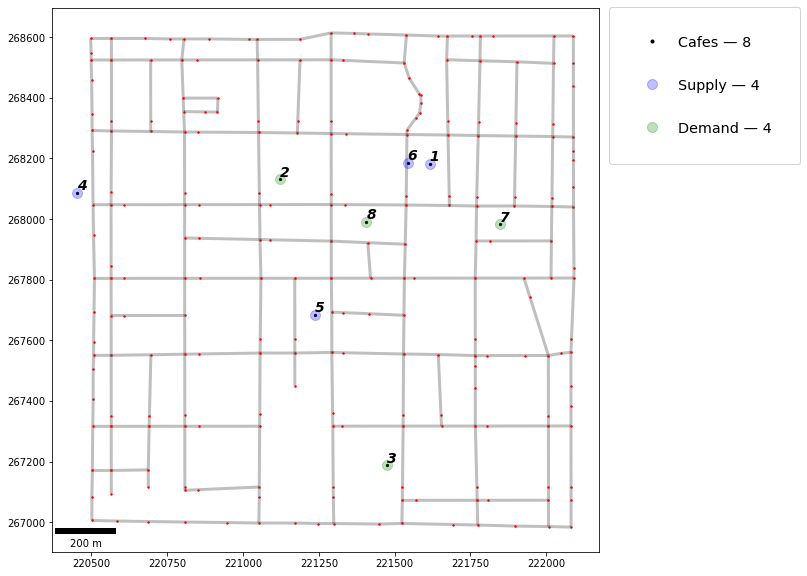

In [84]:
# plot network
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=2, color="red", zorder=1)
# plot observations
cafes.plot(ax=base, markersize=5, color="k", zorder=2)
cafes_supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=2)
cafes_demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
# add labels
obs_labels(cafes, base, 14, col="POLYID", c="k", weight="bold")
# add legend
elements = [cafes, cafes_supply, cafes_demand]
legend(elements)
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

In [85]:
ntw.snapobservations(cafes_supply, "supply")
supply = spaghetti.element_as_gdf(ntw, pp_name="supply")
supply.index.name = "supply"
supply_snapped = spaghetti.element_as_gdf(ntw, pp_name="supply", snapped=True)
supply_snapped.index.name = "supply snapped"
supply_snapped

,id,geometry,comp_label
supply snapped,,,
0,0,POINT (221677.830 268184.321),0
1,1,POINT (220504.720 268087.986),0
2,2,POINT (221292.553 267685.075),0
3,3,POINT (221539.440 268185.067),0


In [86]:
ntw.snapobservations(cafes_demand, "demand")
demand = spaghetti.element_as_gdf(ntw, pp_name="demand")
demand.index.name = "demand"
demand_snapped = spaghetti.element_as_gdf(ntw, pp_name="demand", snapped=True)
demand_snapped.index.name = "demand snapped"
demand_snapped

,id,geometry,comp_label
demand snapped,,,
0,0,POINT (221053.069 268130.545),0
1,1,POINT (221526.519 267187.875),0
2,2,POINT (221847.931 267927.691),0
3,3,POINT (221407.196 268047.138),0


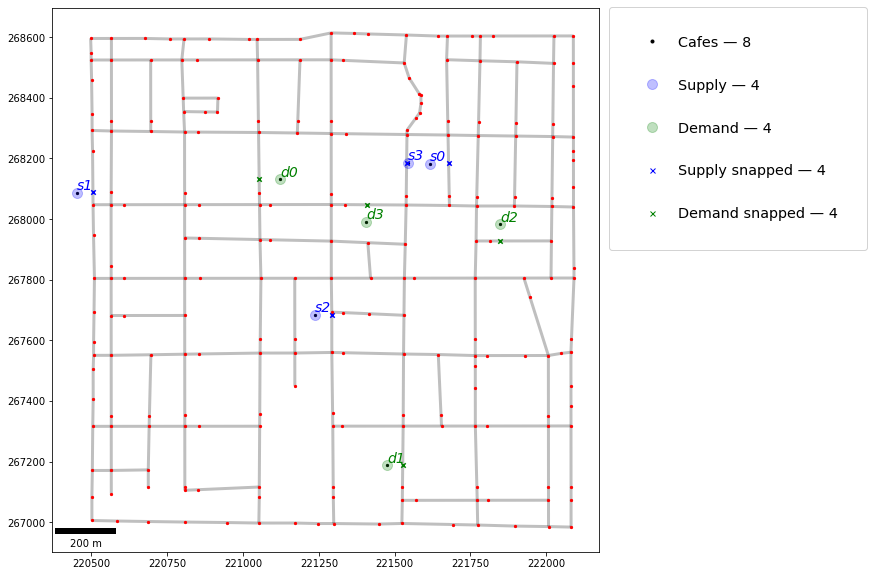

In [87]:
# plot network
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
# plot observations
cafes.plot(ax=base, markersize=5, color="k", zorder=2)
supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=3)
supply_snapped.plot(ax=base, markersize=20, marker="x", color="b", zorder=3)
demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
demand_snapped.plot(ax=base, markersize=20, marker="x", color="g", zorder=3)
# add labels
obs_labels(supply, base, 14, c="b")
obs_labels(demand, base, 14, c="g")
# add legend
elements += [supply_snapped, demand_snapped]
legend(elements)
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);

In [88]:
s2d, tree = ntw.allneighbordistances("supply", "demand", gen_tree=True)
s2d[:3, :3]

array([[ 849.03401966, 1141.08317288,  423.74250057],
       [ 672.67073764, 1903.3759572 , 1500.3287812 ],
       [ 675.53756417,  728.75248715,  796.28485507]])

In [89]:
list(tree.items())[:4], list(tree.items())[-4:]

([((0, 0), (216, 218)),
  ((0, 1), (216, 130)),
  ((0, 2), (216, 173)),
  ((0, 3), (216, 64))],
 [((3, 0), (188, 218)),
  ((3, 1), (188, 130)),
  ((3, 2), (188, 173)),
  ((3, 3), (188, 64))])

In [90]:
supply["dv"] = supply["id"].apply(lambda _id: "s_%s" % _id)
supply["s_i"] = amount_supply
supply

,id,geometry,comp_label,dv,s_i
supply,,,,,
0,0,POINT (221615.157 268183.063),0,s_0,40
1,1,POINT (220453.142 268087.516),0,s_1,60
2,2,POINT (221235.835 267685.028),0,s_2,30
3,3,POINT (221542.706 268185.028),0,s_3,70


In [91]:
demand["dv"] = demand["id"].apply(lambda _id: "d_%s" % _id)
demand["d_j"] = amount_demand
demand

,id,geometry,comp_label,dv,d_j
demand,,,,,
0,0,POINT (221122.271 268131.466),0,d_0,10
1,1,POINT (221474.669 267188.462),0,d_1,90
2,2,POINT (221847.882 267983.231),0,d_2,20
3,3,POINT (221406.839 267990.801),0,d_3,80


In [92]:
s, d, s_i, d_j = supply["dv"], demand["dv"], supply["s_i"], demand["d_j"]
trans_prob = TransportationProblem(s, d, s2d, s_i, d_j)

Minimized shipping costs: 154999.9003

Shipping decisions:
	 x_0,2 20.0
	 x_0,3 20.0
	 x_1,0 10.0
	 x_1,3 50.0
	 x_2,1 30.0
	 x_3,1 60.0
	 x_3,3 10.0


In [93]:
trans_prob.print_lp()


 \Problem name:  TransportationProblem

Minimize
OBJROW: 849.03402 x_0,0 + 1141.08317 x_0,1 + 423.74250 x_0,2 + 413.14052 x_0,3 + 672.67074 x_1,0 + 1903.37596 x_1,1 + 1500.32878 x_1,2 + 942.83080 x_1,3 + 675.53756 x_2,0 + 728.75249 x_2,1
 + 796.28486 x_2,2 + 479.24516 x_2,3 + 705.24863 x_3,0 + 997.29778 x_3,1 + 565.67950 x_3,2 + 269.35512 x_3,3
Subject To
supply(0):  x_0,0 + x_0,1 + x_0,2 + x_0,3 <= 40
supply(1):  x_1,0 + x_1,1 + x_1,2 + x_1,3 <= 60
supply(2):  x_2,0 + x_2,1 + x_2,2 + x_2,3 <= 30
supply(3):  x_3,0 + x_3,1 + x_3,2 + x_3,3 <= 70
demand(0):  x_0,0 + x_1,0 + x_2,0 + x_3,0 >= 10
demand(1):  x_0,1 + x_1,1 + x_2,1 + x_3,1 >= 90
demand(2):  x_0,2 + x_1,2 + x_2,2 + x_3,2 >= 20
demand(3):  x_0,3 + x_1,3 + x_2,3 + x_3,3 >= 80
Bounds
End



In [94]:
paths = ntw.shortest_paths(tree, "supply", "demand")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,geometry,O,D,id
0,"LINESTRING (221677.830 268184.321, 221680.004 ...",0,0,"(0, 0)"
1,"LINESTRING (221677.830 268184.321, 221680.004 ...",0,1,"(0, 1)"
2,"LINESTRING (221677.830 268184.321, 221680.004 ...",0,2,"(0, 2)"
3,"LINESTRING (221677.830 268184.321, 221680.004 ...",0,3,"(0, 3)"
4,"LINESTRING (220504.720 268087.986, 220505.092 ...",1,0,"(1, 0)"


In [95]:
shipments = trans_prob.extract_shipments(paths_gdf, "id")
shipments

,geometry,O,D,id,ship
2,"LINESTRING (221677.830 268184.321, 221680.004 ...",0,2,"(0, 2)",20
3,"LINESTRING (221677.830 268184.321, 221680.004 ...",0,3,"(0, 3)",20
4,"LINESTRING (220504.720 268087.986, 220505.092 ...",1,0,"(1, 0)",10
7,"LINESTRING (220504.720 268087.986, 220505.092 ...",1,3,"(1, 3)",50
9,"LINESTRING (221292.553 267685.075, 221292.655 ...",2,1,"(2, 1)",30
13,"LINESTRING (221539.440 268185.067, 221538.155 ...",3,1,"(3, 1)",60
15,"LINESTRING (221539.440 268185.067, 221538.155 ...",3,3,"(3, 3)",10


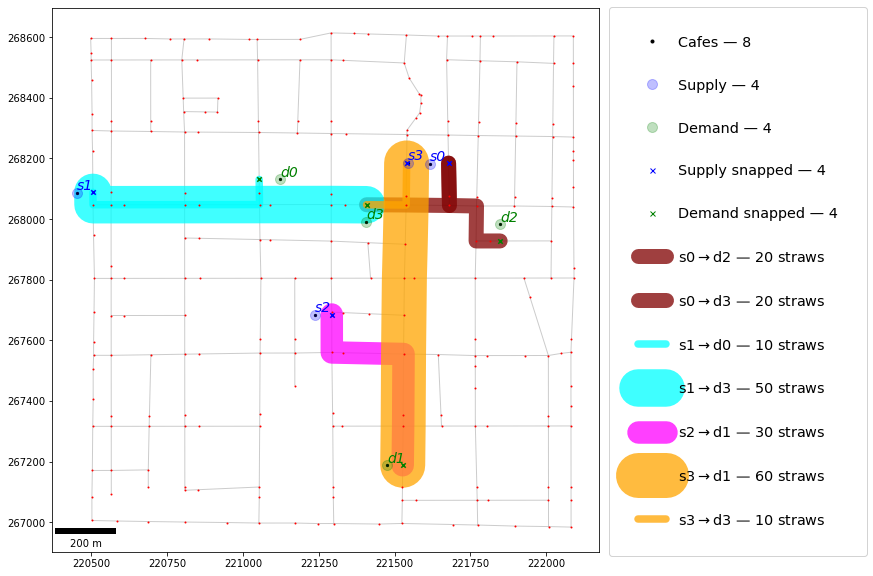

In [96]:
# plot network
base = arcs.plot(alpha=0.2, linewidth=1, color="k", figsize=(10, 10), zorder=0)
vertices.plot(ax=base, markersize=1, color="r", zorder=2)
cafes.plot(ax=base, markersize=5, color="k", zorder=2)
supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=3)
supply_snapped.plot(ax=base, markersize=20, marker="x", color="b", zorder=3)
demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
demand_snapped.plot(ax=base, markersize=20, marker="x", color="g", zorder=3)
# plot shipments
plot_shipments(shipments.groupby("O"), base)
# add labels
obs_labels(supply, base, 14, c="b")
obs_labels(demand, base, 14, c="g")
# add legend
elements += [shipments.groupby("O")]
legend(elements)
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower left")
base.add_artist(scalebar);